# ProjectionPlots and On Screen Mass? 

This notebook walks through projection plots of grid-based and SPH-based datasets for density fields from which you can calculate a total mass captured in the image (the "on screen mass"). You'll be learning about the ProjectionPlot API for on-axis and off-axis projections as well as accessing underlying data contained in plot objects. 

In [ ]:
import yt 
import numpy as np 
import matplotlib.pyplot as plt 

yt.set_log_level(50)

## Grid-Based datasets 

Let's start with a grid-based dataset

In [2]:
ds = yt.load_sample("Enzo_64")

and create a projection plot of the `('gas', 'density')` field: 


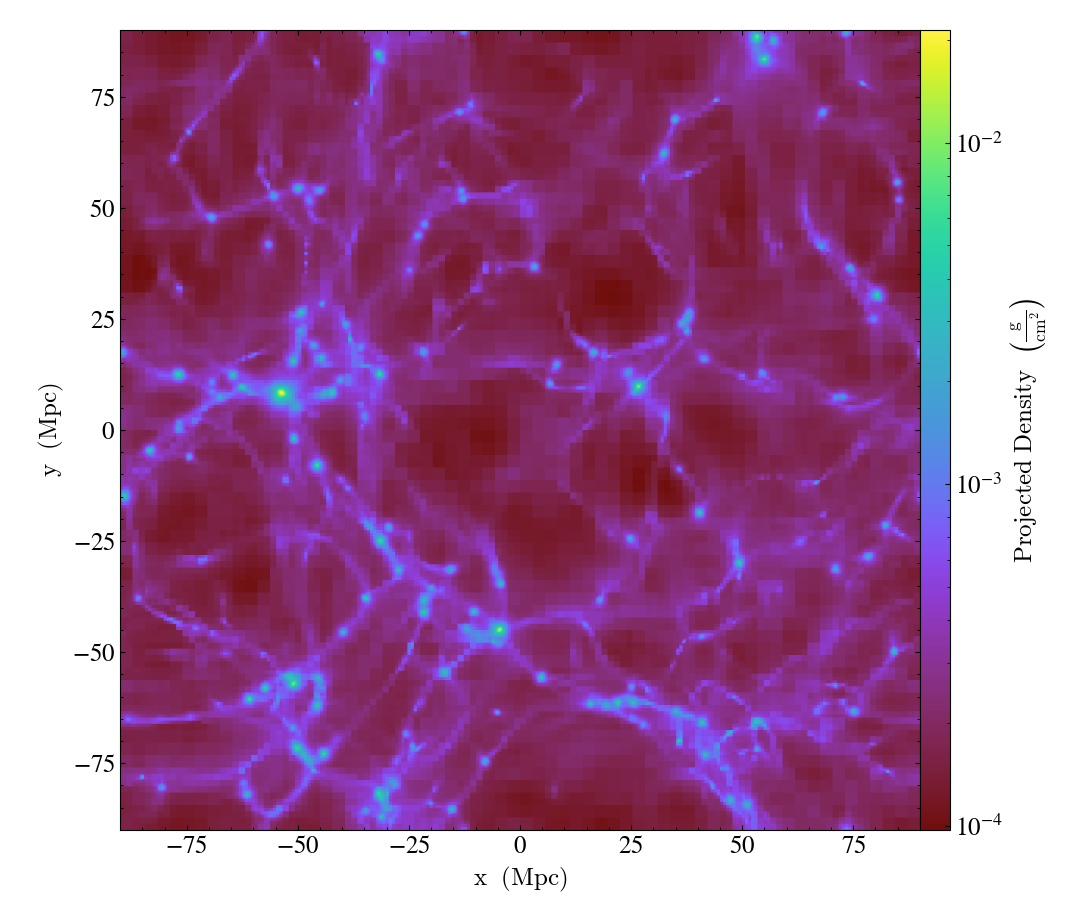

In [23]:
p = yt.ProjectionPlot(ds, 'z', ('gas', 'density'))
p

how does the image vary as you decrease the number of pixels in the image? (check the `yt.ProjectionPlot` help for the argument to vary): 


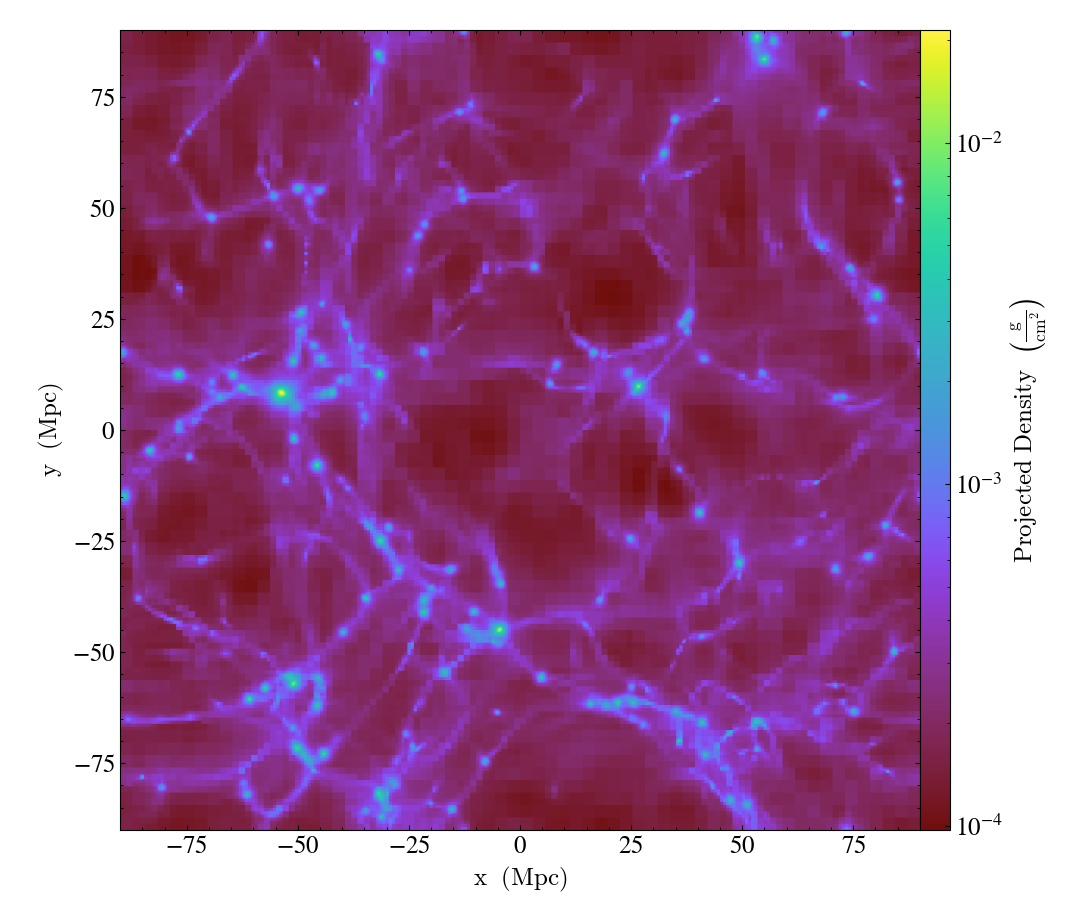


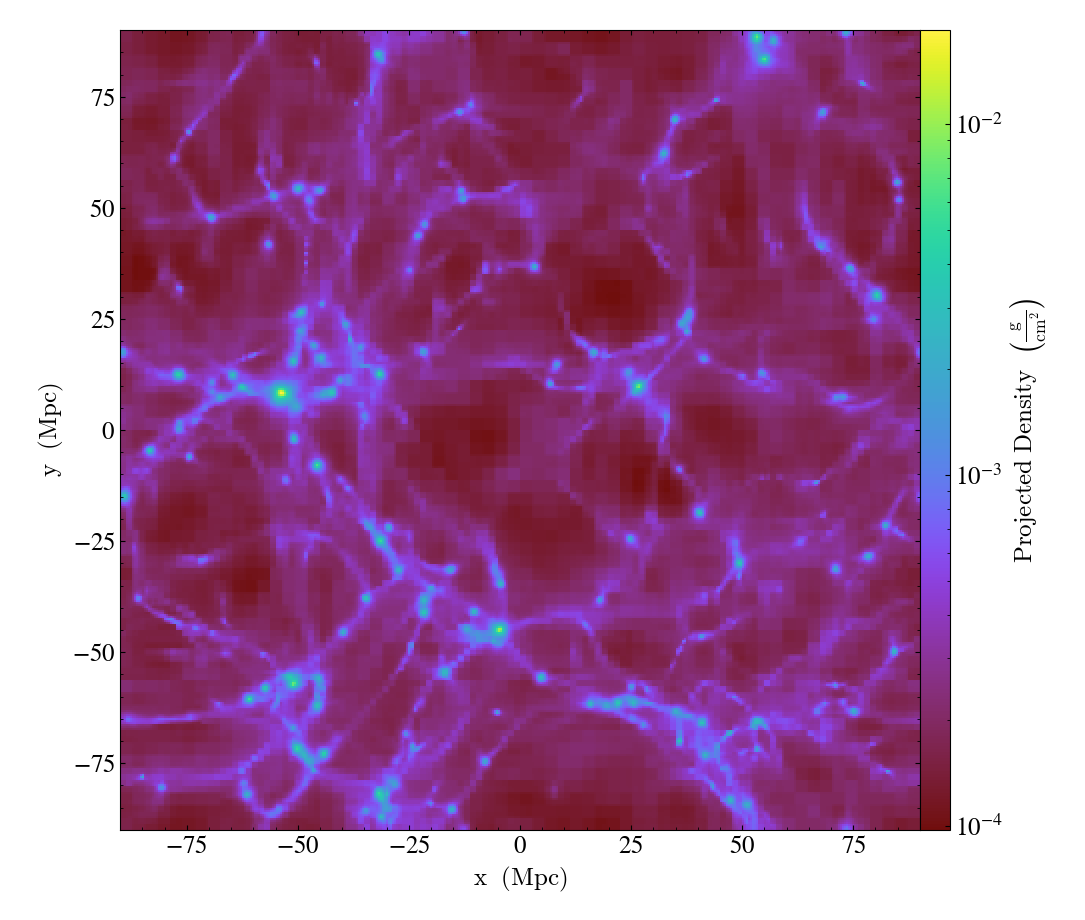


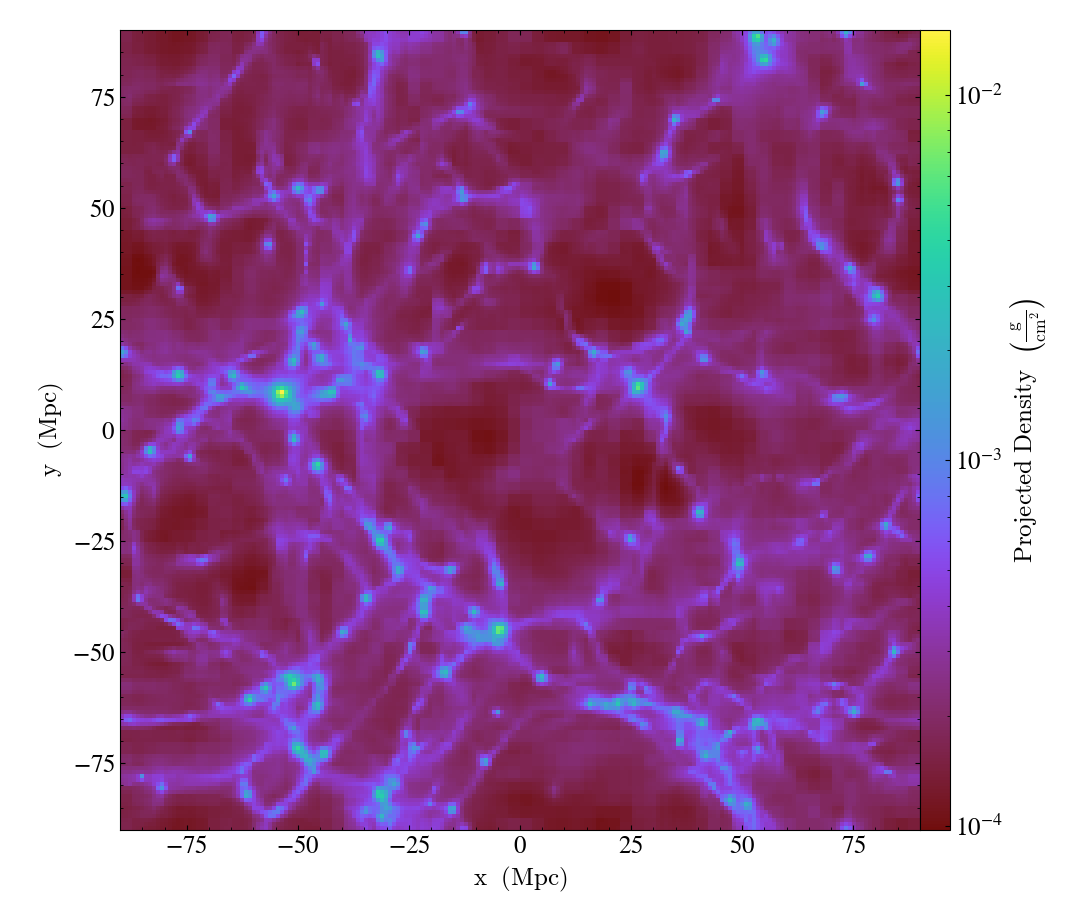


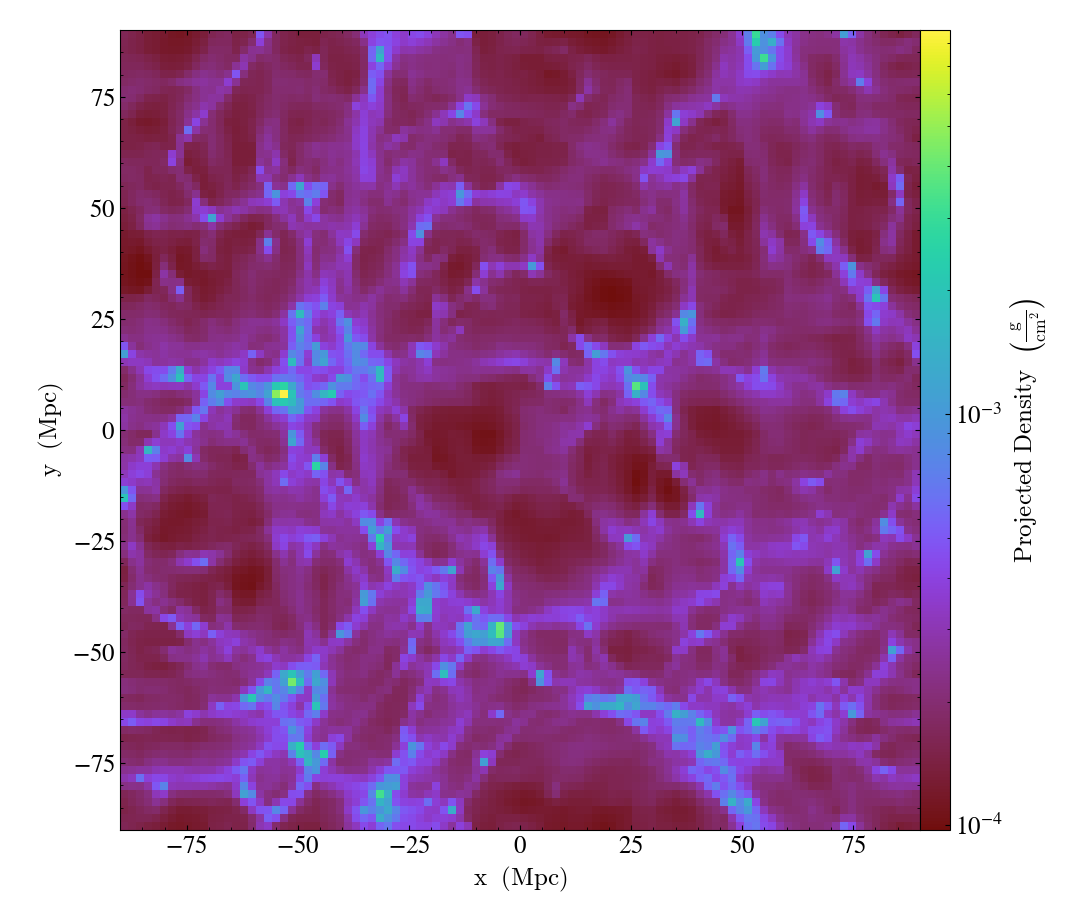


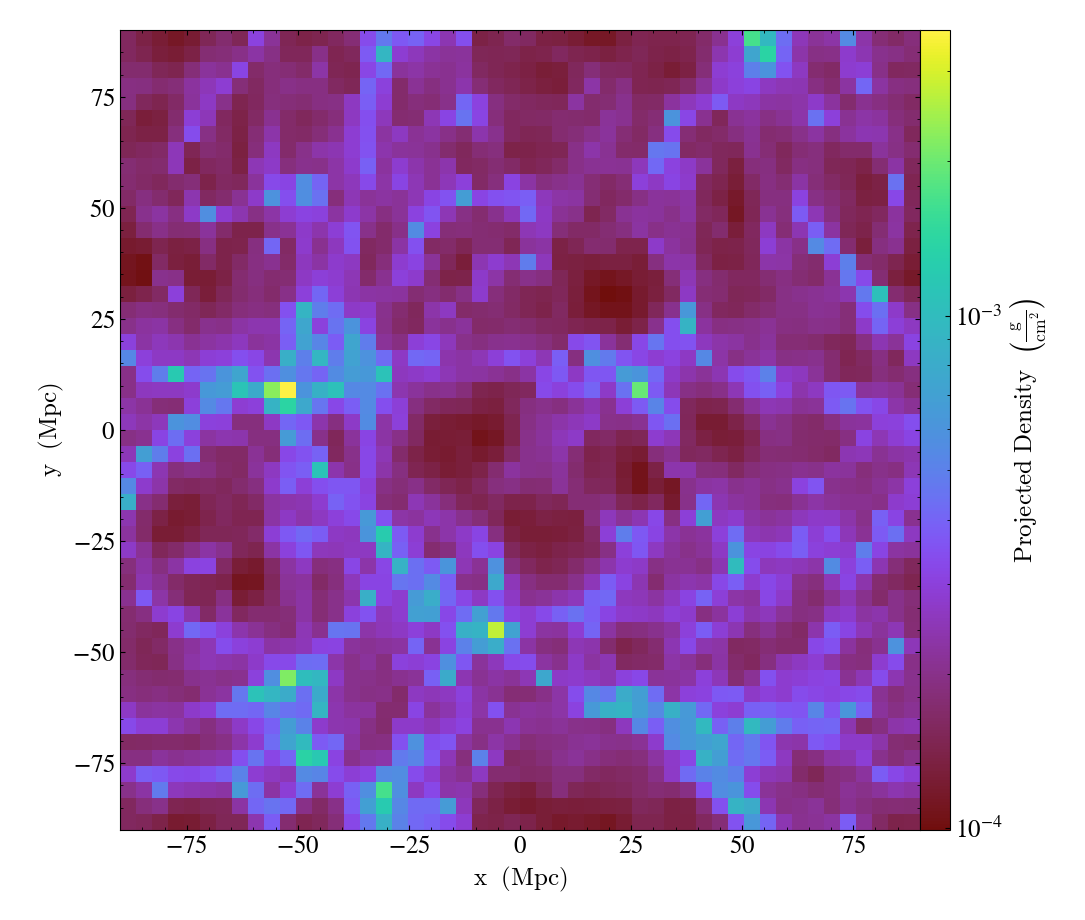


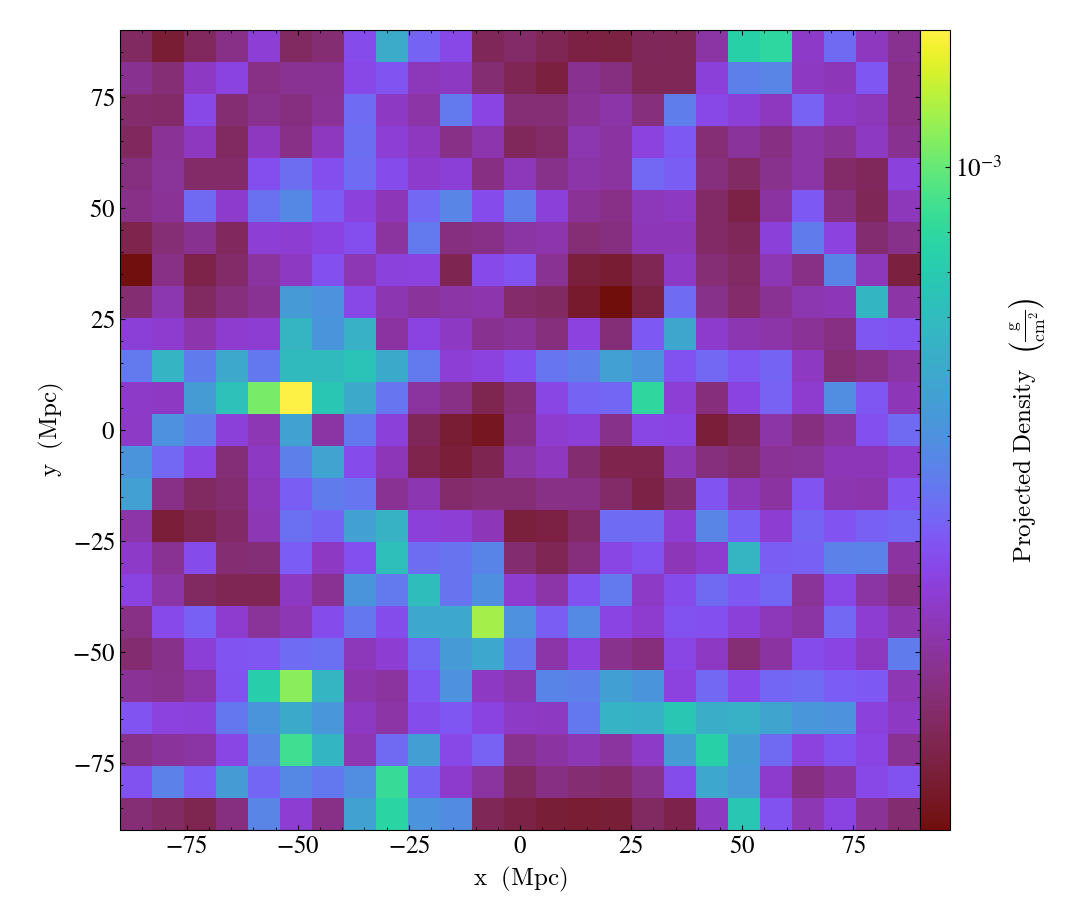

In [26]:
for n_pixs in (400, 200, 100, 50, 25):
    p = yt.ProjectionPlot(ds, 'z', ('gas', 'density'), buff_size=(n_pixs, n_pixs))
    p.show()

(the result should not be surprising). 


But how correct is the result? Let's calculate the total mass represented in the image. 

First, calculate a pixel area using attributes available on the projection plot object, meaning for a projection plot, 

```python
p = yt.ProjectionPlot(...)
```

check out the attributes hanging off of `p.` -- you'll need two to calculate the area of a single pixel: 


In [4]:
p.bounds, p.buff_size

((unyt_quantity(0., 'code_length'),
  unyt_quantity(1., 'code_length'),
  unyt_quantity(0., 'code_length'),
  unyt_quantity(1., 'code_length')),
 (400, 400))

In [5]:
pixel_size_x = (p.bounds[1] - p.bounds[0]) / p.buff_size[0]
pixel_size_y = (p.bounds[3] - p.bounds[2]) / p.buff_size[1]
pixel_area = pixel_size_x * pixel_size_y
n_pixels = np.prod(p.buff_size)
pixel_area, n_pixels

(unyt_quantity(6.25e-06, 'code_length**2'), np.int64(160000))

No, extract the underlying image array data for the projection plot using the available Fixed Resolution Buffer (frb): 

In [6]:
density = p.frb[('gas', 'density')]

Given the projected density values for each pixel and the area of a pixel, calculate the total mass:

In [7]:
on_screen_mass = np.sum(density) * pixel_area 
on_screen_mass

unyt_quantity(8.14061016e+49, 'g')

Compare this to the total mass in the simulation (using other yt operations).

In [8]:
ad = ds.all_data()
t_mass_actual = ad.quantities.total_mass()[0]

In [9]:
(on_screen_mass - t_mass_actual)/t_mass_actual

unyt_quantity(1.27565299e-16, '(dimensionless)')

Now, iterate through some projection plots again (if you didn't already) and store the relative error as a function of the number of pixels in the projection:

In [11]:

def get_on_screen_mass(proj_plot):
    pixel_size_x = (proj_plot.bounds[1] - proj_plot.bounds[0]) / proj_plot.buff_size[0]
    pixel_size_y = (proj_plot.bounds[3] - proj_plot.bounds[2]) / proj_plot.buff_size[1]
    pixel_area = pixel_size_x * pixel_size_y
    
    density = p.frb[('gas', 'density')]
    return np.sum(density) * pixel_area 

def calculate_mass_rel_error(ad, proj_plot):
    on_screen_mass = get_on_screen_mass(proj_plot)
    t_mass_actual = ad.quantities.total_mass()[0]
    return (on_screen_mass - t_mass_actual)/t_mass_actual


In [12]:

result = []
n_pixs = []
for buff_size in np.geomspace(1,1000,20):
    size_1d = int(buff_size)
    n_pixs.append(size_1d ** 2)
    p = yt.ProjectionPlot(ds, 'z', ('gas', 'density'), buff_size=(size_1d, size_1d))
    result.append(calculate_mass_rel_error(ad, p))

plot up that error as a function of number of pixels (using generical matplotlib). How's it do?

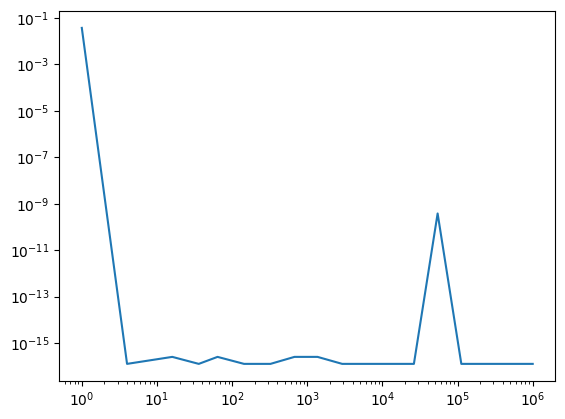

In [13]:
plt.loglog(n_pixs, np.abs(result))

Ok -- **what about off-axis projections**? Do it again but for off-axis plots! 

Choose any normal vector you want, but make sure that your plot bounds capture the whole domain: for example, create a projection plot with a normal vector of (1,1,1) with default arguments:


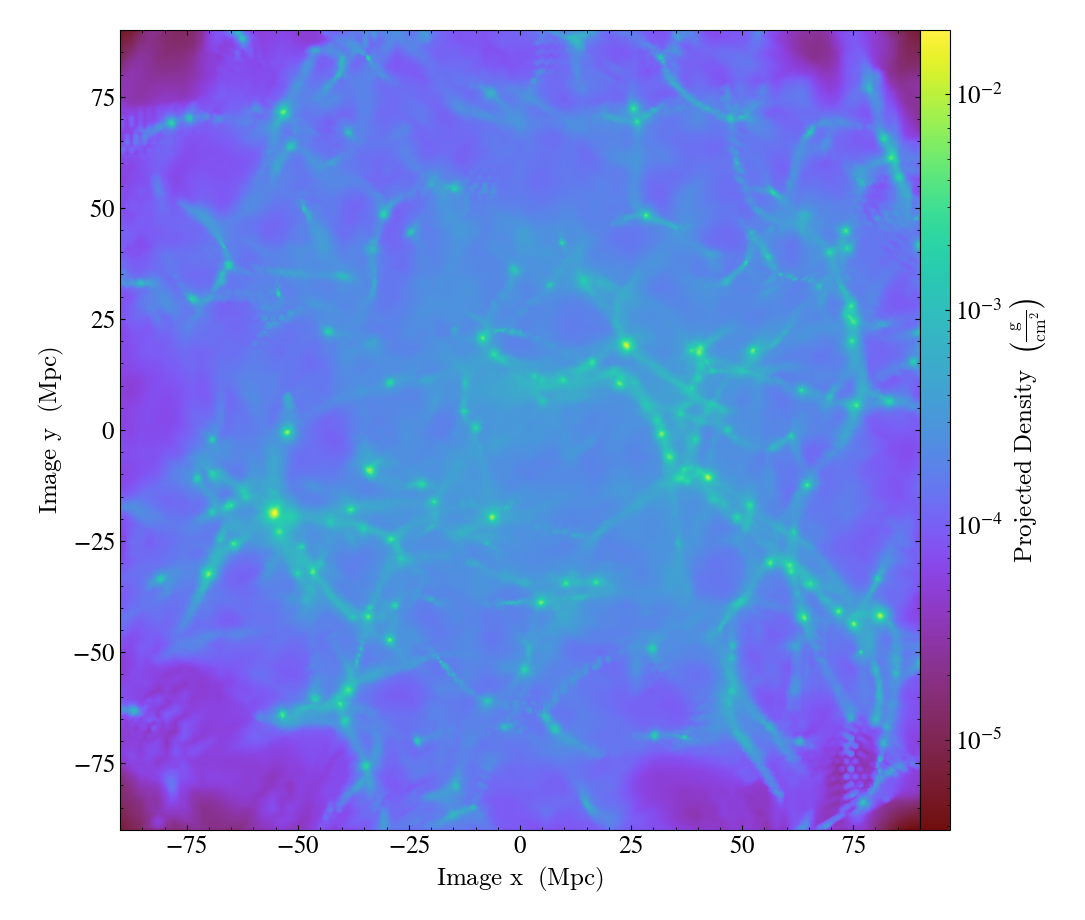

In [27]:
yt.ProjectionPlot(ds, (1,1,1), ('gas', 'density'))

how do you think the on-screen mass would compare to the actual total mass? 

what `ProjectionPlot` argument can you change to capture the whole domain? How big do you need to make it when using a normal vector of (1,1,1)? 


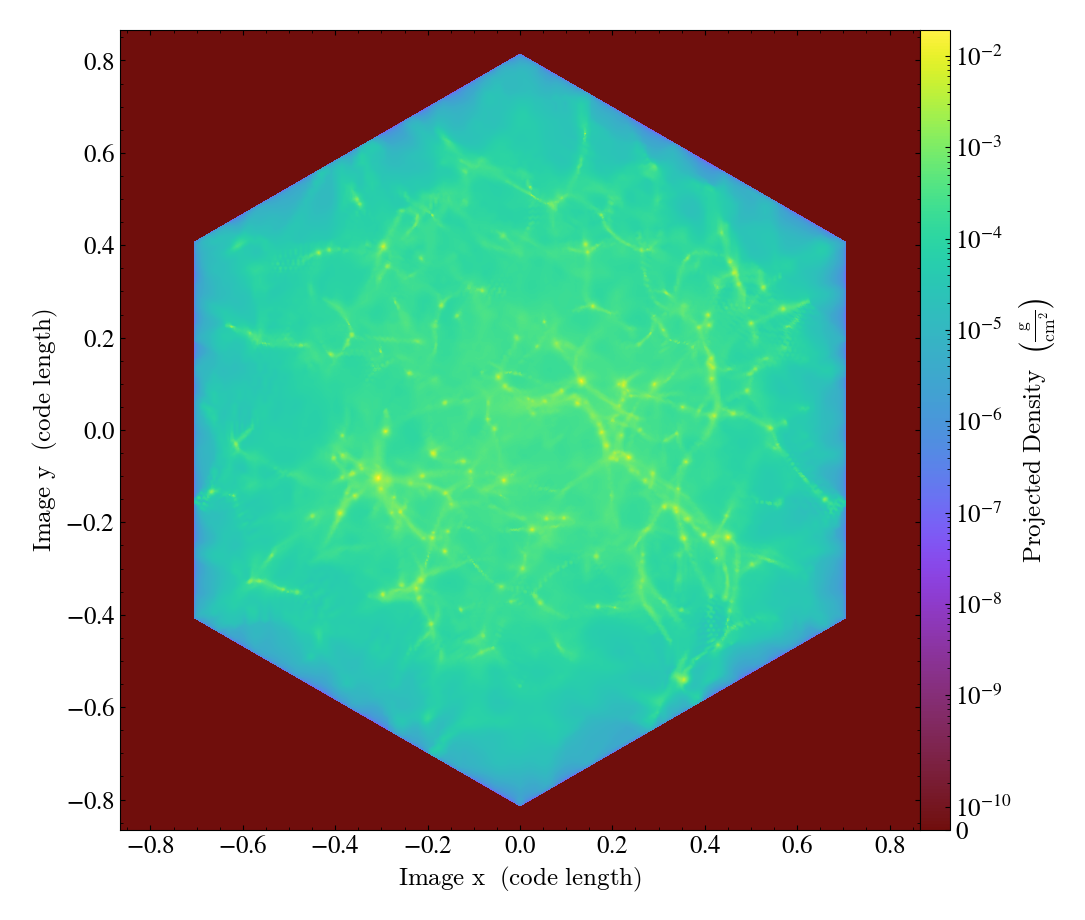

In [29]:
yt.ProjectionPlot(ds, (1,1,1), ('gas', 'density'), 
                  width=np.sqrt(np.dot(ds.domain_width, ds.domain_width))) 

Ok, now calculate and plot that error as a function of number of pixels again for the off-axis projection:

In [30]:
off_ax_result = []
off_ax_n_pixs = []
for power_2 in range(5,13):
    size_1d = int(2**power_2)   
    off_ax_n_pixs.append(size_1d ** 2)
    p = yt.ProjectionPlot(ds, (1,1,1), ('gas', 'density'), 
                          width=np.sqrt(np.dot(ds.domain_width, ds.domain_width)),
                          buff_size=(size_1d, size_1d))
    off_ax_result.append(calculate_mass_rel_error(ad, p))

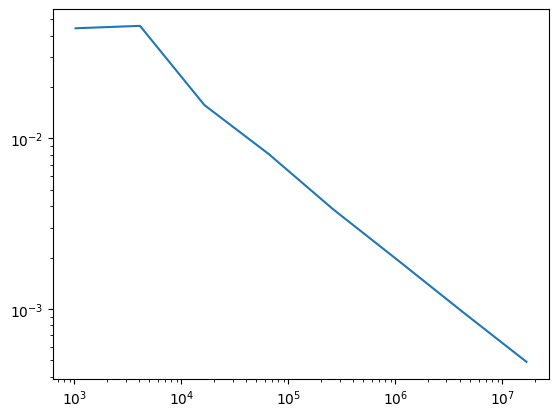

In [31]:
plt.loglog(off_ax_n_pixs, np.abs(off_ax_result))

How's it compare to the axis-aligned case? Any ideas why you see what you observe?

## SPH-Based Datasets

Ok, let's do it all again for an SPH dataset!

Load one up (choose your own if you want!):

In [32]:
ds = yt.load_sample("snapshot_033")
ad = ds.all_data()

Initializing refined index: 100%|███████████████| 12/12 [00:01<00:00,  7.68it/s]


Calculate the error for on- and off- axis projections again:

In [33]:
off_ax_result = []
on_ax_result = []
for power_2 in range(5,13):
    size_1d = int(2**power_2)    

    p = yt.ProjectionPlot(ds, 'z', ('gas', 'density'), buff_size=(size_1d, size_1d))
    on_ax_result.append(calculate_mass_rel_error(ad, p))
    
    p = yt.ProjectionPlot(ds, (1,1,1), ('gas', 'density'), 
                          width=np.sqrt(np.dot(ds.domain_width, ds.domain_width)),
                          buff_size=(size_1d, size_1d))
    off_ax_result.append(calculate_mass_rel_error(ad, p))

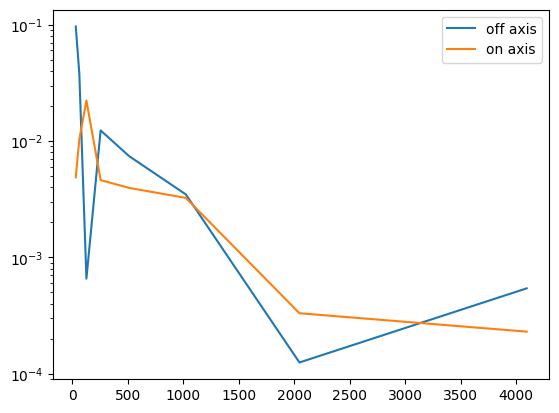

In [40]:
plt.semilogy(np.sqrt(off_ax_n_pixs), np.abs(off_ax_result), label='off axis')
plt.semilogy(np.sqrt(off_ax_n_pixs), np.abs(on_ax_result), label='on axis')
plt.legend()

## Further explorations

* for off-axis projections, how does the error vary as a function of normal vector? Repeat the above analysis but adjust the normal vector systematically at a fixed buffer size. 
* does the type of grid-based dataset matter? The above example is Enzo.... what about a different gridded data type? (try one of the RAMSES sample datasets -- it's an octree-based grid)
  